<p style="color: #000000; font-size: 32px; font-weight: bold; text-align: center; margin-top: 20px;"> 
Sweet Lift Taxi
</p>
<p style="color: #000000; font-size: 24px; text-align: center; margin-bottom: 20px;">
Taxi Order Prediction Model for Airports
</p>

<hr style="border: .4px solid #000000; width: 70%; margin: 10px auto;">

<p style="color: #000000; font-size: 18px;">
The Sweet Lift Taxi company has collected historical data on taxi orders at airports. To improve driver availability during peak hours, a model will be developed to predict the number of taxi orders in the next hour.
</p>

<p style="color: #000000; font-size: 20px; font-weight: bold;">Project Objective:</p>
<p style="color: #000000; font-size: 18px;">
The goal of this project is to build a prediction model that estimates the number of taxi orders with an RMSE metric not exceeding 48 on the test set.
</p>

<p style="color: #000000; font-size: 20px; font-weight: bold;">Project Instructions:</p>
<ul style="color: #000000; font-size: 18px;">
<li><strong>Data Download and Processing:</strong> Resample the data by one-hour intervals.</li>
<li><strong>Exploratory Analysis:</strong> Examine and understand the features of the data.</li>
<li><strong>Model Training:</strong> Test different models and adjust hyperparameters. Use 10% of the initial dataset as a test sample.</li>
<li><strong>Model Evaluation:</strong> Test the model with the test sample and draw conclusions about its performance.</li>
</ul>

<p style="color: #000000; font-size: 20px; font-weight: bold;">Data Description:</p>
<p style="color: #000000; font-size: 18px;">
The data is in the file <code>taxi.csv</code>, which contains two columns.
</p>

<p style="color: #000000; font-size: 18px;">
<strong>datetime</strong> — Date and time, in the format: YYYY-MM-DD HH:MM:SS.
</p>

<p style="color: #000000; font-size: 18px;">
<strong>num_orders</strong> — Number of taxi orders made at the corresponding date and time.
</p>

___

# 1. Data Loading and Preparation

## Libraries

In [2]:
import pandas as pd 
import numpy as np
import math 
import time

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit, train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

In [3]:
# Load the data, setting 'datetime' as the index
data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

# Group by hour
data = data.resample('h').sum()

# Rename the column to 'orders_per_hour'
data = data.rename(columns={data.columns[0]: 'orders_per_hour'})

# Show information and a random sample
data.info()
data.sample(15)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   orders_per_hour  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


,orders_per_hour
datetime,
2018-05-25 07:00:00,34
2018-05-28 11:00:00,121
2018-05-19 13:00:00,86
2018-07-20 01:00:00,119
2018-03-01 18:00:00,73
2018-05-02 14:00:00,54
2018-05-03 18:00:00,56
2018-05-10 19:00:00,45
2018-05-05 04:00:00,30


The initial review shows that there are 26,596 order records, no null values, the data type is correct, and the records are grouped by hour.  
Let's continue with the data description: the date range, whether they are sorted chronologically, and checking for duplicates in the index.

In [4]:
# Date Range
start_date = data.index.min()
end_date = data.index.max()

print(f'Date range: {start_date} - {end_date}')

Date range: 2018-03-01 00:00:00 - 2018-08-31 23:00:00


In [5]:
# Check if the dates are in ascending order
if data.index.is_monotonic_increasing:
    print("The dates are in ascending order (monotonically increasing).")
else:
    print("The dates are NOT in ascending order.")

The dates are in ascending order (monotonically increasing).


In [6]:
# Check for duplicates in the index
print('Duplicates in the index:', data.index.duplicated().sum())

Duplicates in the index: 0


Now let's look at the **order number distribution**.  

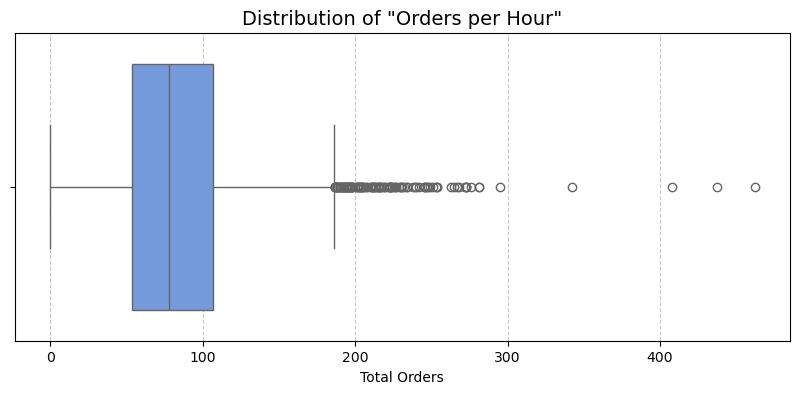

,orders_per_hour
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [7]:
# Boxplot 'orders_per_hour'
plt.figure(figsize=(10, 4))  
sns.boxplot(x=data['orders_per_hour'], color="cornflowerblue") 
plt.title('Distribution of "Orders per Hour"', fontsize=14)
plt.xlabel('Total Orders')
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()
data.describe()

On average, **84 trips per hour** were made, with a standard deviation of **45 trips**, indicating significant variability in demand.

- **Minimum:** There were times when no trips were recorded in a given hour (**0 trips**).  
- **25th Percentile (Q1):** In the 25% of hours with the lowest demand, there were **54 trips or fewer**.  
- **Median (Q2, 50%):** Half of the hours recorded **78 trips or fewer**.  
- **75th Percentile (Q3):** In the hours with higher demand, **107 trips or more** were recorded.  
- **Maximum:** The highest-demand hour recorded **462 trips**, suggesting possible peaks in passenger flow, likely related to key flight schedules.

These data indicate that taxi demand to the airport varies considerably throughout the day and week, with periods of no activity and others of high demand.

In [8]:
# Calculate the upper limit to detect outliers using the Interquartile Range (IQR) method
# The 75th percentile (Q3) and the 25th percentile (Q1) are calculated, then the formula is used:
# Q3 + 1.5 * (Q3 - Q1) to establish the upper threshold for outliers.
upper_limit = data['orders_per_hour'].quantile(0.75) + 1.5 * (data['orders_per_hour'].quantile(0.75) - data['orders_per_hour'].quantile(0.25))

# Count the number of outliers that exceed the upper limit
outliers_count = len(data[data['orders_per_hour'] > upper_limit])

# Calculate the percentage of outliers relative to the total data
outliers_percentage = round(outliers_count / len(data) * 100, 2)

# Display the percentage of outliers
print(f'There are {outliers_count} high outliers, representing {outliers_percentage}% of the values.')

There are 121 high outliers, representing 2.74% of the values.


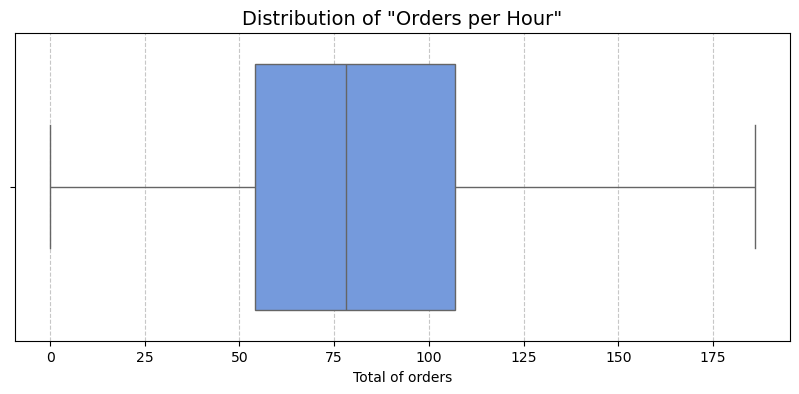

In [9]:
# Truncate the values in the 'orders_per_hour' column to ensure they do not exceed the upper limit.
# 'upper_limit' is the maximum value allowed in the column.
# math.floor is used to round down the limit if necessary.

data['orders_per_hour'] = data['orders_per_hour'].clip(upper=math.floor(upper_limit))

# This will truncate any value in 'orders_per_hour' that is greater than the upper limit 'upper_limit',
# replacing it with 'upper_limit'. If there are no values above the limit, the values will remain unchanged.

# Boxplot for 'orders_per_hour'
plt.figure(figsize=(10, 4))  
sns.boxplot(x=data['orders_per_hour'], color="cornflowerblue") 
plt.title('Distribution of "Orders per Hour"', fontsize=14)
plt.xlabel('Total of orders')
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

We can visually check that the outliers regrouped correctly.

---

## Analysis

In [10]:
# Calculate the moving average with a 24-hour (1-day) window
data['rolling_mean'] = data['orders_per_hour'].rolling(window=24).mean()

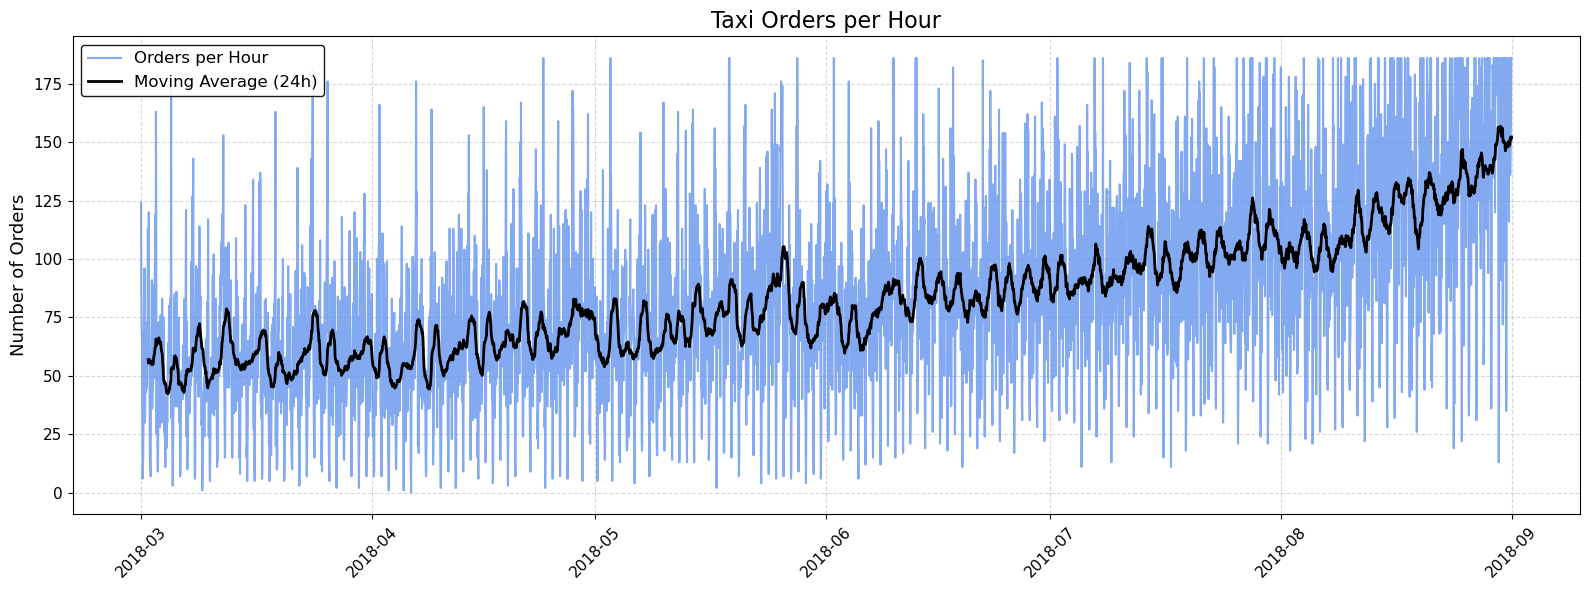

In [11]:
# Configure the figure
plt.figure(figsize=(16, 6))

# Plot the original series of hourly taxi orders
plt.plot(data.index, data['orders_per_hour'], label='Orders per Hour', color='cornflowerblue', linewidth=1.5, alpha=0.8)

# Plot the 24-hour moving average
plt.plot(data.index, data['rolling_mean'], label='Moving Average (24h)', color='black', linewidth=2)
plt.title('Taxi Orders per Hour', fontsize=16)
plt.ylabel('Number of Orders', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)
plt.legend(loc='upper left', fontsize=12, frameon=True, facecolor='white', edgecolor='black', framealpha=0.9)
plt.tight_layout()
plt.show()

**Analysis of 'Taxi Orders per Hour'**  

Since March, the number of hourly orders started at an average of 50-60 and steadily grew, reaching approximately 150 orders per hour in August.  

Peaks are observed during certain hours of the day, especially at night and midday, with regular low trends in the early morning hours.  

Demand increased significantly during the summer months, especially between July and August, while it was lower in spring.

###  2.1. Data Decomposition  

The next step is to break down the data into three main components: **trend**, **seasonal component**, and **residuals**.  
The **trend** shows the overall direction of the data over time, revealing whether orders are increasing, decreasing, or remaining stable.  
The **seasonal component** highlights repetitive patterns, such as daily or weekly peaks, which may be related to specific hours or days of the week.  
Finally, the **residuals** represent what is not explained by either the trend or seasonality, helping to identify anomalies or noise in the data.  
This decomposition is key to better understanding order behavior and making informed decisions.

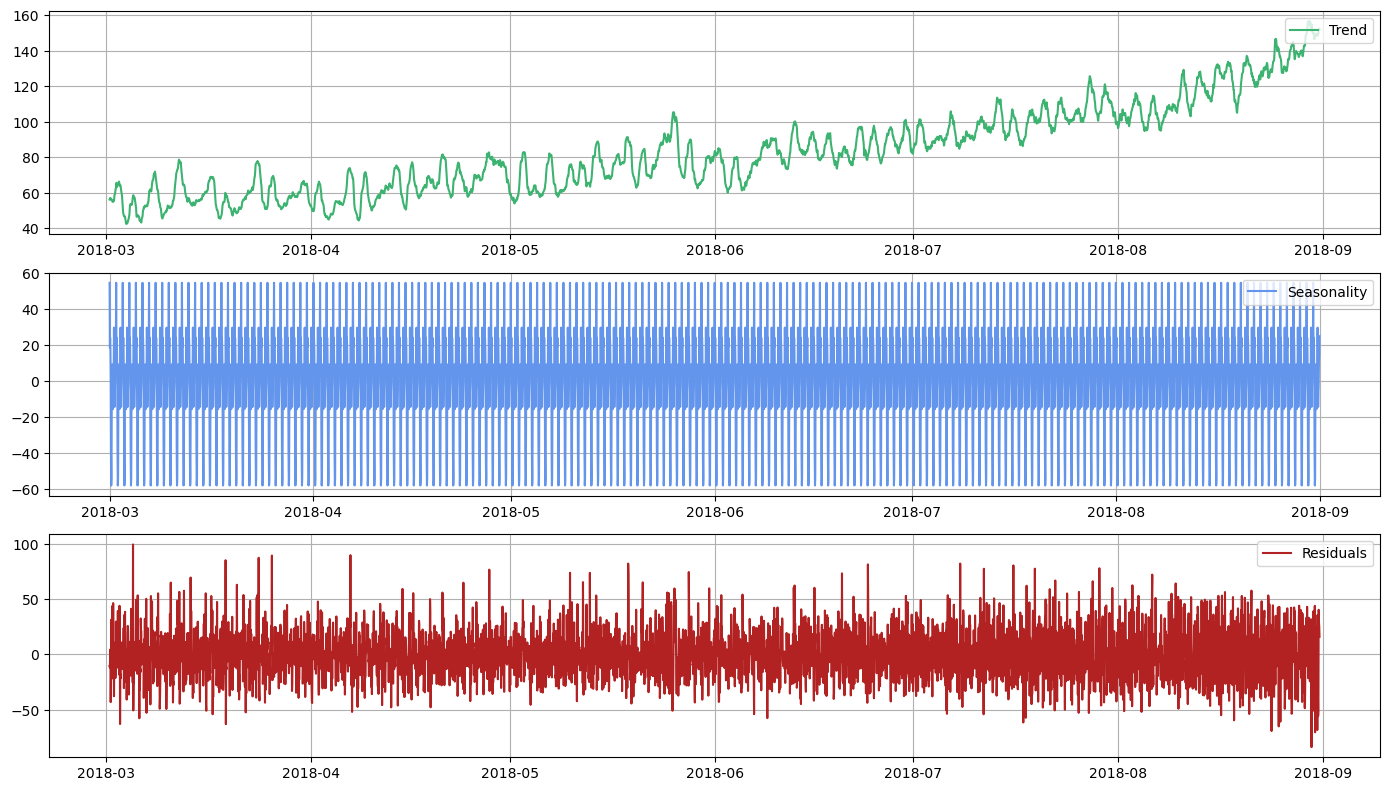

In [12]:
# Time Series Decomposition
decomposition = seasonal_decompose(data['orders_per_hour'], model='additive', period=24)  # 24-hour period

# Plot the components
plt.figure(figsize=(14, 8))

# Trend
plt.subplot(3, 1, 1)
plt.plot(decomposition.trend, label='Trend', color='mediumseagreen')
plt.legend(loc='upper right')
plt.grid()

# Seasonality
plt.subplot(3, 1, 2)
plt.plot(decomposition.seasonal, label='Seasonality', color='cornflowerblue')
plt.legend(loc='upper right')
plt.grid()

# Residuals
plt.subplot(3, 1, 3)
plt.plot(decomposition.resid, label='Residuals', color='firebrick')
plt.legend(loc='upper right')
plt.grid()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

**Time Series Decomposition Analysis (March - August 2018) of Taxi Orders from the Airport**  

**Trend (green):** Shows steady growth since March (approximately 60 orders), with accelerated growth notably during the summer months, ending in August at around 140 orders.  

**Seasonality (blue):** Displays a regular and cyclical pattern that repeats daily. The fluctuations remain consistent between +40 and -40.  

**Residuals (red):** Do not show clear trends, suggesting that the main patterns are well captured by the trend and seasonality.  

Together, these three components explain the overall behavior of taxi orders, indicating a growing business with stable daily patterns and normal random variations.

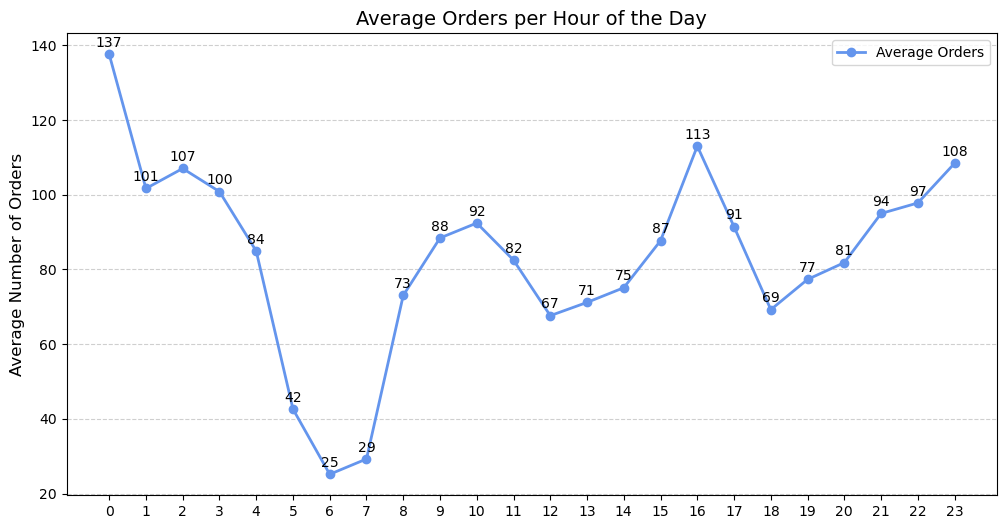

In [13]:
# Group by hour and calculate the average number of orders
hourly_orders = data.groupby(data.index.hour)['orders_per_hour'].mean()

# Configure the figure
plt.figure(figsize=(12, 6))

# Plot the average number of orders per hour as a line chart
plt.plot(hourly_orders.index, hourly_orders.values, marker='o', linestyle='-', color='cornflowerblue', linewidth=2, label='Average Orders')
plt.title('Average Orders per Hour of the Day', fontsize=14)
plt.ylabel('Average Number of Orders', fontsize=12)
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add values above each point on the line
for i, value in enumerate(hourly_orders.values):
    plt.text(hourly_orders.index[i], value + 2, f'{int(value)}', ha='center', fontsize=10)

# Add a legend
plt.legend()
# Show the plot
plt.show()

**Analysis of the Average Taxi Orders per Hour from the Airport**  

The chart shows the average number of taxi orders per hour during a full day (0-23 hours), revealing several significant demand patterns from the airport:  

The chart presents clear and distinct patterns. The **highest peak** occurs at midnight (0:00 hours), with an average of 140 orders, suggesting intense activity related to late-night flights. After that, there is a **low-demand period** between 5 and 8 AM, reaching its lowest point (about 25 orders) between 6 and 7 AM. During the day, **two significant peaks** are identified: one around 10 AM (90 orders) and another more pronounced one at 4 PM (16:00 hours), with nearly 115 orders. In the evening hours (8-11 PM), demand remains **consistently high**, fluctuating between 95-110 orders per hour, indicating sustained activity during this period.  

**Overall trend**: Demand follows a pattern that aligns with typical airport operating hours, with higher activity during the night and early morning hours, and a notable decrease in the early hours of the morning.  

This information suggests the need for strategic planning in taxi availability: maximizing the fleet during peak demand periods (midnight and afternoon) and optimizing it during low-activity hours (early morning). This distribution would allow for better resource management and a more efficient response to user needs.

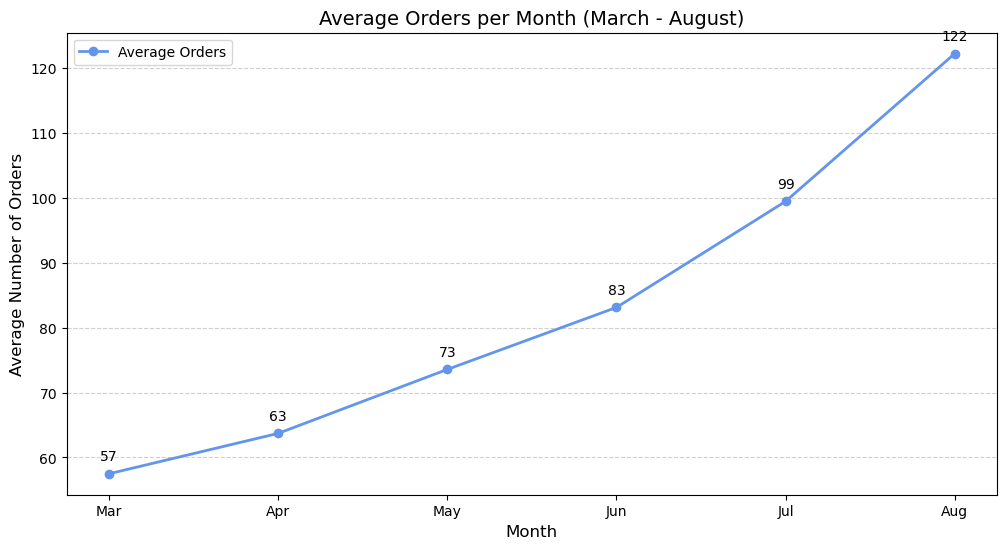

In [14]:
# Group by month and calculate the average number of orders
monthly_orders = data.groupby(data.index.month)['orders_per_hour'].mean()

# Filter only the months from March to August
months = range(3, 9)  # March (3) to August (8)
monthly_orders = monthly_orders.loc[months]

# Configure the figure
plt.figure(figsize=(12, 6))

# Plot the average number of orders per month as a line
plt.plot(monthly_orders.index, monthly_orders.values, marker='o', linestyle='-', color='cornflowerblue', linewidth=2, label='Average Orders')
plt.title('Average Orders per Month (March - August)', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Number of Orders', fontsize=12)
# Adjust the x-axis to show only the months from March to August
plt.xticks(monthly_orders.index, labels=['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug'])
# Show grid on the y-axis
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add values above each point on the line
for i, value in enumerate(monthly_orders.values):
    plt.text(monthly_orders.index[i], value + 2, f'{int(value)}', ha='center', fontsize=10)

# Add a legend
plt.legend()
# Show the plot
plt.show()

**Analysis of the Average Average Orders per Month (March - August)**  

The data period spans from spring to summer, and we can see that as temperatures rise, airport arrivals increase.

The chart shows a steady increase in the total number of orders from spring (March-May) to summer (June-August). At the beginning of spring, in **March**, the total number of orders is 57, slightly increasing to **63 orders in April** and reaching **73 orders in May**. This upward trend continues into the summer transition, where **June** reaches 83, **July** sees a more notable increase with 99, and **August** marks the highest peak with 122 orders.

The black trend line reflects a steady and accelerated growth, especially pronounced during the summer months. This pattern can be explained by factors such as the **increase in tourism during summer**, **higher flight activity during peak season**, and **better weather conditions**, which favor travel and, therefore, taxi demand.

## 3. Model Training and Testing

**Features are created for forecasting:**  
   Variables are generated that will help the models predict demand. These features include relevant information such as dates, past values, and trends.

**Exploration of key features:**  
   The following features are used for the predictive models (except for the constant model):  
   - **Calendar features:** such as month, day of the month, and day of the week.  
   - **Lag features:** Previous order values to identify patterns of increase or decrease.  
   - **Moving average feature:** Captures the overall trend of the time series.

**Model training with different hyperparameters:**  
   Several predictive models are tested, adjusting their hyperparameters to find the best combination that improves prediction accuracy.

In [15]:
# It is deleted to create an updated one
data = data.drop('rolling_mean', axis = 1)

In [16]:
# Create time-based features
data['hour'] = data.index.hour  # Hour of the day
data['day_of_week'] = data.index.dayofweek  # Day of the week (0 = Monday, 6 = Sunday)
data['day_of_month'] = data.index.day  # Day of the month
data['week_of_year'] = data.index.isocalendar().week  # Week of the year

# Create a binary feature for weekends
data['is_weekend'] = data['orders_per_hour'].apply(lambda x: 1 if x >= 5 else 0)

# Create lag features
for lag in [1, 2, 3, 24, 168]:  # Lags of 1, 2, 3 hours, 1 day (24h), and 1 week (168h)
    data[f'lag_{lag}'] = data['orders_per_hour'].shift(lag)

# Create rolling mean features
data['rolling_mean_3'] = data['orders_per_hour'].shift(1).rolling(window=3).mean()  # 3-hour rolling mean
data['rolling_mean_24'] = data['orders_per_hour'].shift(1).rolling(window=24).mean()  # 24-hour rolling mean

# Drop rows with NaN values
data.dropna(inplace=True)

# Show the first rows of the dataframe
display(data.head())

,orders_per_hour,hour,day_of_week,day_of_month,week_of_year,is_weekend,lag_1,lag_2,lag_3,lag_24,lag_168,rolling_mean_3,rolling_mean_24
datetime,,,,,,,,,,,,,
2018-03-08 00:00:00,143,0,3,8,10,1,94.0,127.0,108.0,100.0,124.0,109.666667,60.041667
2018-03-08 01:00:00,78,1,3,8,10,1,143.0,94.0,127.0,121.0,85.0,121.333333,61.833333
2018-03-08 02:00:00,65,2,3,8,10,1,78.0,143.0,94.0,24.0,71.0,105.000000,60.041667
2018-03-08 03:00:00,68,3,3,8,10,1,65.0,78.0,143.0,66.0,66.0,95.333333,61.750000
2018-03-08 04:00:00,60,4,3,8,10,1,68.0,65.0,78.0,73.0,43.0,70.333333,61.833333


**Data Splitting**

In [17]:
# Set up cross-validation for time series with 5 splits
# TimeSeriesSplit divides the data into multiple partitions, respecting the temporal order
# Each "split" will use more training data while evaluating with future data
tss = TimeSeriesSplit(n_splits=5)

In [18]:
# Separate features and target variable (target: 'orders_per_hour')
features = data.drop(columns=['orders_per_hour'])
target = data['orders_per_hour']

# Split the dataset into training and testing sets
# - test_size=0.1: 10% of the data is reserved for testing
# - shuffle=False: Do not shuffle the data (useful for time series or sequential data)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.1, shuffle=False
)

# Check the sizes of the created sets
print('Train shape (features): ', features_train.shape)  
print('Test shape (features): ', features_test.shape)
print('Train shape (target): ', target_train.shape)
print('Test shape (target): ', target_test.shape)

Train shape (features):  (3823, 12)
Test shape (features):  (425, 12)
Train shape (target):  (3823,)
Test shape (target):  (425,)


### Model 1: Linear Regression

In [19]:
# Train the linear regression model
linear_model = LinearRegression()
linear_model.fit(features_train, target_train)

# Predict and evaluate
linear_pred = linear_model.predict(features_test)
linear_rmse = np.sqrt(mean_squared_error(target_test, linear_pred))
print(f"Linear Regression\n RMSE: {linear_rmse:.2f}") 

Linear Regression
 RMSE: 25.82


### Model 2: Decision Tree Regressor
`RandomizedSearchCV` is used to optimize hyperparameters.

In [20]:
# Define the hyperparameters to optimize
param_dist = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None] 
}

# Create the model and RandomizedSearchCV
tree_model = DecisionTreeRegressor(random_state=12345)
tree_search = RandomizedSearchCV(tree_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)

# Train and optimize
tree_search.fit(features_train, target_train)

# Predict and evaluate
tree_pred = tree_search.predict(features_test)
tree_rmse = np.sqrt(mean_squared_error(target_test, tree_pred))
print(f"Decision Tree\n RMSE: {tree_rmse:.2f}")
print(f"Best hyperparameters:\n {tree_search.best_params_}")

Decision Tree
 RMSE: 29.28
Best hyperparameters:
 {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10}


### Model 3:  Random Forest Regressor
`RandomizedSearchCV` is used to optimize hyperparameters.

In [22]:
# Define the hyperparameters to optimize
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Create the model and RandomizedSearchCV
forest_model = RandomForestRegressor(random_state=12345)
forest_search = RandomizedSearchCV(forest_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)

# Train and optimize
forest_search.fit(features_train, target_train)

# Predict and evaluate
forest_pred = forest_search.predict(features_test)
forest_rmse = np.sqrt(mean_squared_error(target_test, forest_pred))
print(f"Random Forest\n RMSE: {forest_rmse:.2f}")
print(f"Best hyperparameters:\n {forest_search.best_params_}")

Random Forest
 RMSE: 28.10
Best hyperparameters:
 {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 15}


### Model 4: LGBMRegressor
`RandomizedSearchCV` is used to optimize hyperparameters.

In [23]:
# Define the hyperparameters to optimize
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 100],
    'min_child_samples': [10, 20, 30]
}

# Create the model and RandomizedSearchCV
lgbm_model = LGBMRegressor(random_state=12345)
lgbm_search = RandomizedSearchCV(lgbm_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)

# Train and optimize
lgbm_search.fit(features_train, target_train)

# Predict and evaluate
lgbm_pred = lgbm_search.predict(features_test)
lgbm_rmse = np.sqrt(mean_squared_error(target_test, lgbm_pred))
print(f"\nLightGBM\n RMSE: {lgbm_rmse:.2f}")
print(f"Best hyperparameters:\n {lgbm_search.best_params_}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1465
[LightGBM] [Info] Number of data points in the train set: 3058, number of used features: 11
[LightGBM] [Info] Start training from score 84.650098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1416
[LightGBM] [Info] Number of data points in the train set: 3059, number of used features: 11
[LightGBM] [Info] Start training from score 72.523047
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1462
[LightGBM] [Info] Number of data points in the train set: 3058, number of used features: 11
[LightGBM] [Info] Start training from score 82.405821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1465
[LightGBM] [Info] Number of data points in the train set: 3058, number of used features: 11
[LightGBM] [Info] Start training from score 84.650098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 3059, number of used features: 11
[LightGBM] [Info] Start training from score 76.772802
[LightGBM] [Warning] No further splits with positive gain,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1465
[LightGBM] [Info] Number of data points in the train set: 3058, number of used features: 11
[LightGBM] [Info] Start training from score 84.650098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhea

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

### Model 5: CatBoost
`RandomizedSearchCV` is used to optimize hyperparameters.

In [25]:
# Define the hyperparameters to optimize
param_dist = {
    'iterations': [100, 200, 300],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5]
}

# Create the model and RandomizedSearchCV
catboost_model = CatBoostRegressor(random_state=12345, verbose=0)
catboost_search = RandomizedSearchCV(catboost_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)

# Train and optimize
catboost_search.fit(features_train, target_train)

# Predict and evaluate
catboost_pred = catboost_search.predict(features_test)
catboost_rmse = np.sqrt(mean_squared_error(target_test, catboost_pred))
print(f"CatBoost\n- RMSE: {catboost_rmse:.2f}")
print(f"Best hyperparameters:\n {catboost_search.best_params_}")

CatBoost
- RMSE: 27.63
Best hyperparameters:
 {'learning_rate': 0.05, 'l2_leaf_reg': 5, 'iterations': 200, 'depth': 8}


**Compare Resutls**

In [26]:
# Create a dictionary with the results
results = {
    "Linear Regression": {"RMSE": linear_rmse},
    "Decision Tree": {"RMSE": tree_rmse},
    "Random Forest": {"RMSE": forest_rmse},
    "LightGBM": {"RMSE": lgbm_rmse},
    "CatBoost": {"RMSE": catboost_rmse}
}

# Convert the dictionary into a DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index')
# Sort the DataFrame by the 'RMSE' column from lowest to highest
results_df = results_df.sort_values(by='RMSE', ascending=True)

# Display the table
print('\nSummary of results:\n', results_df)


Summary of results:
                         RMSE
Linear Regression  25.820724
CatBoost           27.632752
Random Forest      28.100823
Decision Tree      29.278586
LightGBM           29.293611


**All models have an RMSE lower than 48**

Although the **Linear Regression** model has the lowest RMSE, tree-based models like **CatBoost** and **Random Forest** exhibit comparable performance and could be preferable when capturing more complex relationships. The **Decision Tree** and **LightGBM** also perform reasonably well, but their performance depends more on how the hyperparameters are tuned. Despite these differences, all models are effective for predictions and perform acceptably within the established margin (RMSE below 48).

### 3.1 Analysis of Models on the Test Set

### Random Forest

In [27]:
%%time
# Define the CatBoost model
catboost_model = CatBoostRegressor(
    iterations=200,  # Number of iterations
    depth=5,         # Depth of the tree
    learning_rate=0.05,  # Learning rate
    random_state=12345,  # Seed for reproducibility
    verbose=0         # Mute logs
)

# Train the model
catboost_model.fit(features_train, target_train)
# Predict on the test set
catboost_pred = catboost_model.predict(features_test)

# Calculate RMSE
catboost_rmse = np.sqrt(mean_squared_error(target_test, catboost_pred))
print(f"CatBoost - RMSE on test set: {catboost_rmse:.2f}")

CatBoost - RMSE on test set: 27.09
CPU times: user 264 ms, sys: 184 ms, total: 448 ms
Wall time: 132 ms


### CatBoost Regressor

In [28]:
%%time
# Define the Random Forest model
forest_model = RandomForestRegressor(
    n_estimators=200,  # Number of trees
    max_depth=5,       # Maximum depth of the tree
    random_state=12345    # Seed for reproducibility
)

# Train the model
forest_model.fit(features_train, target_train)

# Predict on the test set
forest_pred = forest_model.predict(features_test)

# Calculate RMSE
forest_rmse = np.sqrt(mean_squared_error(target_test, forest_pred))
print(f"Random Forest - RMSE on test set: {forest_rmse:.2f}")

Random Forest - RMSE on test set: 29.06
CPU times: user 877 ms, sys: 7.48 ms, total: 885 ms
Wall time: 882 ms


**Comparison of CatBoost and Random Forest Results**

| Model               | RMSE on Test Set | Execution Time (Wall Time) |
|---------------------|------------------|----------------------------|
| **CatBoost**         | 27.09            | 131 ms                     |
| **Random Forest**    | 29.06            | 892 ms                     |

**CatBoost** has shown a slightly lower RMSE (27.09) compared to **Random Forest** (29.06), indicating better performance on this dataset.  
**CatBoost** is also faster, with an execution time of 131 ms, while **Random Forest** takes 892 ms, suggesting that CatBoost is more efficient in terms of time for this dataset.

Both models perform quite well, but **CatBoost appears to be more efficient both in accuracy and execution time**.